In [7]:
import copy

import matplotlib as mpl
import numpy as np
from fusiondls import LRBv21, file_read
from matplotlib.ticker import StrMethodFormatter

colors = ["teal","darkorange","firebrick","limegreen","magenta","cyan","navy"]

# Here are some useful labels to use for plotting throughout notebook
store_labels = dict()
store_labels["cvar"] = {"density" : "$n_{u}\ (m^{-3})$",
                        "power" : "$q_{\parallel}\ (Wm^{-2})$",
                        "impurity_frac" : "$f_{z}$"}
store_labels["crel"] = {"density" : "$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$",
                        "power" : "$q_{\parallel}\ /\ q_{\parallel0} (Wm^{-2})$",
                        "impurity_frac" : "$f_{z}\ /\ f_{z0}$"}

store_names =         {"density" : "$n_{u}\ /\ n_{u0}$",
                        "power" : "$q_{\parallel0}\ /\ q_{\parallel}$",
                        "impurity_frac" : "$f_{z}\ /\ f_{z0}$"}

store_cnames =         {"density" : "$[n_{u}\ /\ n_{u0}]^{1}$",
                        "power" : "$[q_{\parallel0}\ /\ q_{\parallel}]^{5/7}$",
                        "impurity_frac" : "$[f_{z}\ /\ f_{z0}]^{0.5}$"}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and visualise equilibrium
- SPR38 inner and outer, visualised.

In [2]:
eqb = file_read("eqb_store.pkl")
data = eqb["SPR38"] # Pick design to use for study

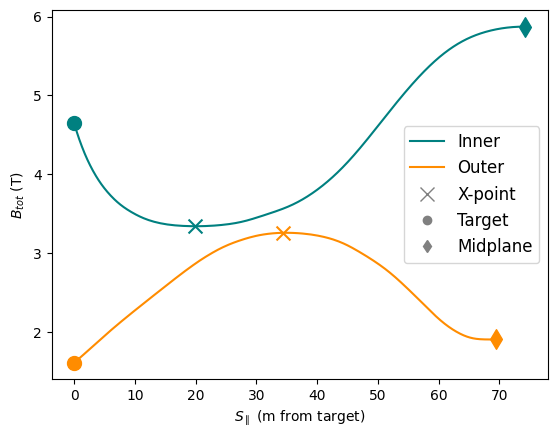

In [3]:
fig, ax = plt.subplots()

labels = {"ou":"Outer", "iu":"Inner"}
size = 100

for i, side in enumerate(["iu", "ou"]):
    d = data[side]
    Xpoint = d["Xpoint"]
    ax.plot(d["S"], d["Btot"], color = colors[i], label = labels[side])
    ax.scatter(d["S"][Xpoint], d["Btot"][Xpoint], color = colors[i], marker = "x", s = size)
    ax.scatter(d["S"][0], d["Btot"][0], color = colors[i], marker = "o", s = size)
    ax.scatter(d["S"][-1], d["Btot"][-1], color = colors[i], marker = "d", s = size)

ax.set_xlabel("$S_{\parallel}$ (m from target)")
ax.set_ylabel("$B_{tot}$ (T)")
ax.legend()

h,l = ax.get_legend_handles_labels()
extra_handles = [
    mpl.lines.Line2D([0], [0], color = "grey", marker = "x", linewidth=0, label = "X-point", markersize = 10),
    mpl.lines.Line2D([0], [0], color = "grey", marker = "o", linewidth=0, label = "Target"),
    mpl.lines.Line2D([0], [0], color = "grey", marker = "d", linewidth=0, label = "Midplane")]

ax.legend(fontsize = 12, handles = h+extra_handles)

# Scan through manipulated profiles in terms of upstream plasma density
- Take the outer divertor and scale it to different upstream connection lengths, downstream connection lengths and flux expansions.
- For each scaled profile, run a front position scan to find trends in window and threshold later.

In [4]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True, # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5, # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, # Upstream density (if constant)
    "nu0" : 1e20, # Upstream density (if constant)
    "cz0" : 0.02, # Impurity fraction (if constant)
    
    "Lfunc": LfuncKallenbachAr, # impurity cooling function. More are available in AnalyticCoolingCurves.py
}


## Scale upstream length Lm

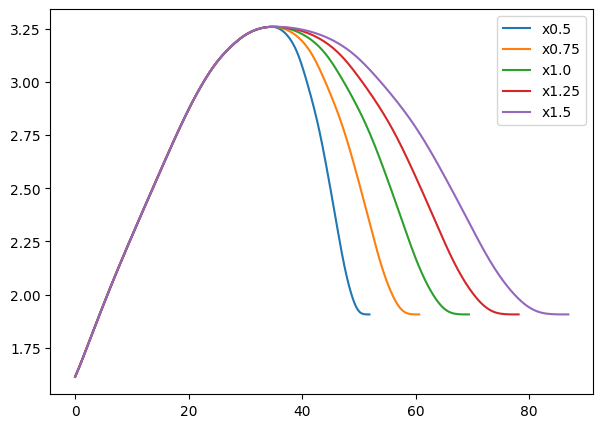

In [5]:
# d_lmscale[0] = copy.deepcopy(data["ou"])
d_lmscale = dict()
list_Lm_scales = np.array([0.5, 0.75, 1, 1.25, 1.50])
side = "ou"

fig, ax = plt.subplots(figsize = (7,5))
for case in list_Lm_scales:
    d = copy.deepcopy(data["ou"])
    d["S"], d["Spol"] = scale_Lm(d["S"], d["Spol"], d["Xpoint"], scale_factor = case)
    d_lmscale[case] = d
    ax.plot(d["S"], d["Btot"], label = f"x{case}")
    
ax.legend()

In [9]:
list_cvars = ["density"]
store = dict()
 
for cvar in list_cvars:
    store[cvar] = dict()
    print(f"Variable {cvar}...", end = "")

    for case in list_Lm_scales:
        print("Case {}...".format(case))
        d = d_lmscale[case].copy()
        constants = constants_default.copy()
        radios = radios_default.copy()
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 5)
        store[cvar][case] = LRBv21(constants, radios, d, SparRange, verbosity = 0, control_variable = cvar)

lmscan = copy.deepcopy(store)

Variable density...Case 0.5...
Solving...0.00...8.38...16.75...25.13...33.50...Complete in 1.9 seconds
Case 0.75...
Solving...0.00...8.38...16.75...25.13...33.50...Complete in 1.7 seconds
Case 1.0...
Solving...0.00...8.38...16.75...25.13...33.50...Complete in 1.6 seconds
Case 1.25...
Solving...0.00...8.38...16.75...25.13...33.50...Complete in 1.6 seconds
Case 1.5...
Solving...0.00...8.38...16.75...25.13...33.50...Complete in 1.7 seconds


## Scale downstream length Lx

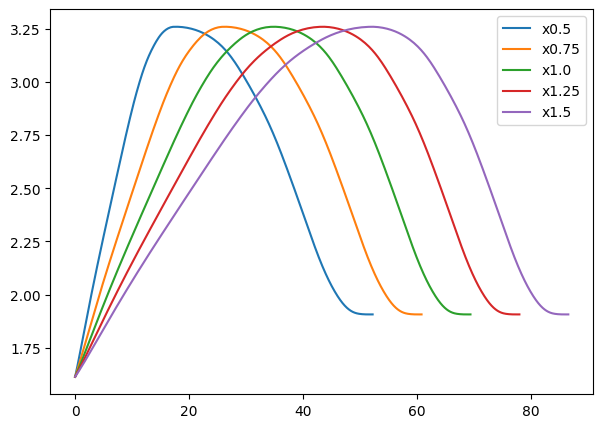

In [10]:
d_lxscale = dict() # store scaled profiles here.
list_Lx_scales = np.array([0.5, 0.75, 1, 1.25, 1.50]) # scale by these scale factors.
side = "ou"

fig, ax = plt.subplots(figsize = (7,5))
for case in list_Lx_scales:
    d = copy.deepcopy(data["ou"])
    d["S"], d["Spol"] = scale_Lc(d["S"], d["Spol"], d["Xpoint"], scale_factor = case)
    d_lxscale[case] = d
    ax.plot(d["S"], d["Btot"], label = f"x{case}")
    
ax.legend()

In [11]:
list_cvars = ["density"]
store = dict()
 
for cvar in list_cvars:
    store[cvar] = dict()
    print(f"Variable {cvar}...", end = "")

    for case in list_Lx_scales:
        print("Case {}...".format(case))
        d = d_lxscale[case].copy()
        constants = constants_default.copy()
        radios = radios_default.copy()
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 5)
        store[cvar][case] = LRBv21(constants, radios, d, SparRange, verbosity = 0, control_variable = cvar)

lxscan = copy.deepcopy(store)

Variable density...Case 0.5...
Solving...0.00...4.19...8.38...12.56...16.75...Complete in 1.5 seconds
Case 0.75...
Solving...0.00...6.28...12.56...18.85...25.13...Complete in 1.4 seconds
Case 1.0...
Solving...0.00...8.38...16.75...25.13...33.50...Complete in 1.5 seconds
Case 1.25...
Solving...0.00...10.47...20.94...31.41...41.88...Complete in 2.2 seconds
Case 1.5...
Solving...0.00...12.56...25.13...37.69...50.26...Complete in 1.7 seconds


## Scale flux expansion Bx/Bt

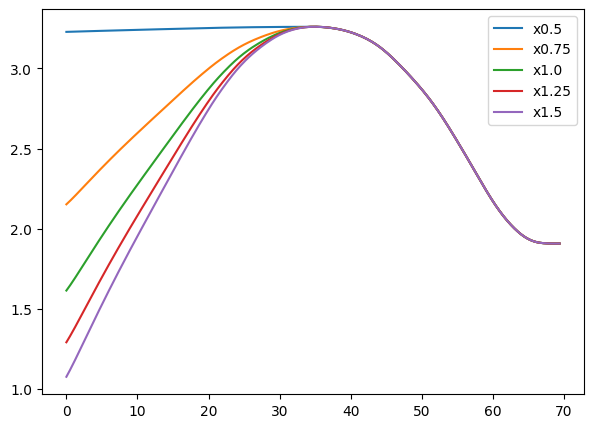

In [12]:
d_BxBtscale = dict()
list_BxBt_scales = np.array([0.5, 0.75, 1, 1.25, 1.50])
side = "ou"

fig, ax = plt.subplots(figsize = (7,5))
for case in list_BxBt_scales:
    d = copy.deepcopy(data["ou"])
    d["Btot"]= scale_BxBt(d["Btot"], d["Xpoint"], scale_factor = case)
    d_BxBtscale[case] = d
    ax.plot(d["S"], d["Btot"], label = f"x{case}")
    
ax.legend()

In [13]:
list_cvars = ["density"]
store = dict()
 
for cvar in list_cvars:
    store[cvar] = dict()
    print(f"Variable {cvar}...", end = "")

    for case in list_BxBt_scales:
        print("Case {}...".format(case))
        d = d_BxBtscale[case].copy()
        constants = constants_default.copy()
        radios = radios_default.copy()
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 5)
        store[cvar][case] = LRBv21(constants, radios, d, SparRange, verbosity = 0, control_variable = cvar)

bxbtscan = copy.deepcopy(store)

Variable density...Case 0.5...
Solving...0.00...8.38...16.75...25.13...33.50...Complete in 1.5 seconds
Case 0.75...
Solving...0.00...8.38...16.75...25.13...33.50...Complete in 1.6 seconds
Case 1.0...
Solving...0.00...8.38...16.75...25.13...33.50...Complete in 1.6 seconds
Case 1.25...
Solving...0.00...8.38...16.75...25.13...33.50...Complete in 1.6 seconds
Case 1.5...
Solving...0.00...8.38...16.75...25.13...33.50...Complete in 1.7 seconds


# Post-processing

## Collect the three scans into data structure

In [14]:
studies = dict()

# Collect labels and data of the three scans------------------------------------
scales = [list_Lx_scales, list_Lm_scales, list_BxBt_scales]
stores = [lxscan, lmscan, bxbtscan]
datas = [d_lxscale, d_lmscale, d_BxBtscale]
names = ["$L_x$ scan", "$L_m$ scan", "$B_X/B_t$ scan"]

# Collect results of the three scans--------------------------------------------
thresholds = dict()
windows = dict()
w_ratio = dict()
t_ratio = dict()

for g in range(3):
    
    thresholds[g] = []
    windows[g] = []

    for i, case in enumerate(scales[g]):
        o = stores[g][cvar][case]
        Xpoint = datas[g][case]["Xpoint"]
        windows[g].append(o["window_ratio"])
        thresholds[g].append(o["threshold"])

    windows[g] = np.array(windows[g])
    thresholds[g] = np.array(thresholds[g])

    w_ratio[g] = windows[g]/windows[g][2]
    t_ratio[g] = 1/ (thresholds[g]/thresholds[g][2])

# Collect average B and total L for scaling purposes------------------------------
Bavg_scales = [None]*3
Ltot_scales = [None]*3

for g in range(3):
    
    Bavgs = []
    Ltots = []
    for i, case in enumerate(scales[g]):
        d = datas[g][case]
        Bavgs.append(np.mean(d["Btot"][:d["Xpoint"]]))
        Ltots.append(d["S"][-1])

    Bavg_scales[g] = np.array(Bavgs) / Bavgs[2]
    Ltot_scales[g] = np.array(Ltots) / Ltots[2]

# Misc-------------------------------------------------------------------------
studies["density"] = copy.deepcopy(stores)

## Plot trends in threshold and window for each scan

- Detachment threshold: density required for detachment.
- Detachment window: ratio of density when front is at the X-point to when it is at the target. (operational window)
- DLS-Extended no longer has the same scalings as the original DLS due to finite width radiation region effects

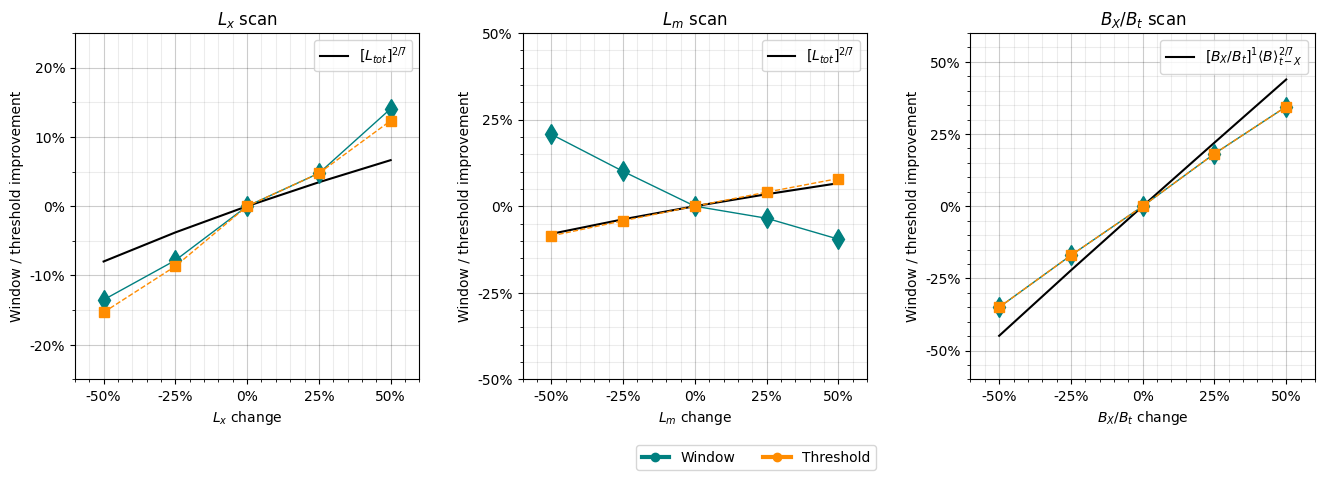

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(16,4.5), sharey = False)
fig.subplots_adjust(wspace=.3)
for g in range(3):
    ax = axes[g]
    ax.set_title(names[g])
    ax.plot(scales[g]-1, w_ratio[g]-1, marker = "d", linestyle = "solid", color = colors[0], markersize = 10, linewidth = 1)
    ax.plot(scales[g]-1, t_ratio[g]-1, marker = "s", linestyle = "dashed", color = colors[1], markersize = 7, linewidth = 1)
    ax.set_xlabel("{} change".format(names[g].replace(" scan","")))
    
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_major_locator(MultipleLocator(0.25))
    ax.yaxis.set_major_locator(MultipleLocator(0.25))
    ax.xaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.grid(which="major", color = "black", alpha = 0.2)
    ax.grid(which="minor", color = "black", alpha = 0.075)
    ax.set_ylim(-0.60,0.60)
    ax.set_xlim(-0.60, 0.60)
    
axes[0].set_ylim(-0.25, 0.25)
axes[1].set_ylim(-0.50, 0.50)
axes[0].yaxis.set_major_locator(MultipleLocator(0.1))
    
zorder_scalings = 0
linewidth_scalings = 1.5
scale = 3/7
axes[0].plot(list_Lx_scales-1, Ltot_scales[1]**(2/7)-1, color = "black", linestyle = "solid", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{tot}]^{2/7}$")
axes[1].plot(list_Lm_scales-1, Ltot_scales[1]**(2/7)-1, color = "black", linestyle = "solid", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = "$[L_{tot}]^{2/7}$")
axes[2].plot(list_Lm_scales-1, list_BxBt_scales*(Bavg_scales[2]**(2/7))-1, color = "black", linestyle = "solid", linewidth = linewidth_scalings, zorder = zorder_scalings,
            label = r"$[B_X/B_t]^{1} {\langle}B{\rangle}^{2/7}_{t-X}$")

for ax in axes:
    ax.legend()
    ax.set_ylabel("Window / threshold improvement")
legend_elements = [
    mpl.lines.Line2D([0], [0], color=colors[0], lw=3, marker = "o", label = "Window"),
    mpl.lines.Line2D([0], [0], color=colors[1], lw=3, marker = "o", label = "Threshold")]

fig.legend(handles = legend_elements, ncol = 5, bbox_to_anchor =(0.63,-0.02))